In [207]:
import pandas as pd
import re

# Part 1 specific
import sqlalchemy
from pathlib import Path

# Part 2 specific
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import utils
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
# ignore the warning you might get from importing ensemble from sklearn
from sklearn import ensemble


In [166]:
## create dataframes from csv data
all_players = pd.read_csv("./data/all_players_2019.csv")
all_teams = pd.read_csv("./data/all_teams_2019.csv")

all_pac12_players = pd.read_csv("./data/pac12_2019_players.csv")
all_pac12_teams = pd.read_csv("./data/pac12_2019_teams.csv")

In [167]:
all_players

,Unnamed: 0,_player_id,_name,_height,_weight,_position,_season,_team_abbreviation,_minutes_played,_total_rebounds,...,_three_point_percentage,_offensive_rebounds,_assists,_turnovers,_usage_percentage,_offensive_win_shares,_defensive_rebounds,_steals,_blocks,_defensive_win_shares
0,jaren-lewis-1,jaren-lewis-1,Jaren Lewis,6-6,215lb,Guard-Forward,2018-19,abilene-christian,1056,208,...,0.333,77,93,60,25.0,2.6,131,54,22,2.4
1,payten-ricks-1,payten-ricks-1,Payten Ricks,6-2,190lb,Guard,2018-19,abilene-christian,1098,95,...,0.395,6,65,46,18.0,2.1,89,57,1,2.2
2,jaylen-franklin-1,jaylen-franklin-1,Jaylen Franklin,6-2,205lb,Guard,2018-19,abilene-christian,1092,126,...,0.450,15,166,70,18.0,2.2,111,61,8,2.3
3,jalone-friday-1,jalone-friday-1,Jalone Friday,6-9,235lb,Center,2018-19,abilene-christian,502,107,...,0.377,25,22,46,32.6,0.9,82,16,22,1.2
4,hayden-farquhar-1,hayden-farquhar-1,Hayden Farquhar,6-7,215lb,Forward,2018-19,abilene-christian,481,87,...,0.386,35,27,24,22.6,1.4,52,22,8,1.0
5,bj-maxwell-1,bj-maxwell-1,B.J. Maxwell,6-5,190lb,Guard,2018-19,abilene-christian,642,113,...,0.405,37,40,20,16.0,1.8,76,26,9,1.3
6,joe-pleasant-1,joe-pleasant-1,Joe Pleasant,6-8,220lb,Forward,2018-19,abilene-christian,498,89,...,0.286,34,10,37,21.0,0.7,55,10,5,0.9
7,damien-daniels-1,damien-daniels-1,Damien Daniels,5-7,140lb,Guard,2018-19,abilene-christian,510,53,...,0.283,12,61,32,16.1,0.3,41,20,1,0.9
8,trey-lenox-1,trey-lenox-1,Trey Lenox,6-3,220lb,Guard,2018-19,abilene-christian,520,41,...,0.432,6,22,19,8.6,0.2,35,14,1,0.8
9,clay-gayman-1,clay-gayman-1,Clay Gayman,6-6,220lb,Forward,2018-19,abilene-christian,155,30,...,0.421,14,8,17,24.8,0.1,16,7,3,0.3


# Functional Library for Normalizing Data

ALL functions below creates a copy of the df to not modify the actual dataframes directly

In [5]:
## Returns a copy of the dataframe with the specific desired columns
def get_desired_columns_from_df(df, columns_wanted):
    copied = df.copy()
    return copied[columns_wanted]

## Gets rid of the string valued columns and normalizes the data
def normalize_data(df):
    ## Select mean and std
    team_desc = df.describe().loc['mean':'std']
    team_means = team_desc.loc['mean']
    team_std = team_desc.loc['std']
    
    # teams_selected_columns.iloc[:,1:]
    values_useful = df.copy()
    values_useful.index = values_useful['abbreviation']
    values_useful = values_useful.drop(['abbreviation','name', 'conference'], axis=1)
    return (((values_useful - team_means) / team_std), team_means, team_std)

## normalizes the data, assuming the dataframe has no string values
def normalize_nonstring_data(df):
    ## Select mean and std
    team_desc = df.describe().loc['mean':'std']
    team_means = team_desc.loc['mean']
    team_std = team_desc.loc['std']
    
    # teams_selected_columns.iloc[:,1:]
    values_useful = df.copy()
    return (((values_useful - team_means) / team_std), team_means, team_std)




# Normalize the all team dataframe (includes train and test splits)

We create 6 different data frames and find important summary statistics (mean and std), which can be categorized into 2 groups


#### Raw
1. All the teams `raw` data, mean, and std
2. The training `raw` data, mean, and std
3. The testing `raw` data, mean, and std

#### Normalized 
1. All the teams `normalized` data, mean, and std
2. The training `normalized` data, mean, and std
3. The testing `normalized` data, mean, and std


### Split all the teams into train and split

In [6]:
## Split up data into train and test splits
raw_train_teams, raw_test_teams = train_test_split(all_teams, test_size = 0.2,random_state = 100)

## Get raw all teams mean and std
raw_all_teams_mean = all_teams.describe().loc['mean']
raw_all_teams_std = all_teams.describe().loc['std']

## Get the raw train mean and std
raw_train_mean = raw_train_teams.describe().loc['mean']
raw_train_std = raw_train_teams.describe().loc['std']

## Get the raw test mean and std
raw_test_mean = raw_test_teams.describe().loc['mean']
raw_test_std = raw_test_teams.describe().loc['std']

### Create the normalized versions for all teams, training, and testing data

In [7]:
team_columns_wanted = ["abbreviation","name","conference","assists","blocks","field_goal_percentage","free_throw_percentage",
                   "free_throw_attempts","losses","net_rating","offensive_rating","offensive_rebounds",
                   "opp_assists","opp_field_goal_percentage","opp_offensive_rating","opp_three_point_field_goal_percentage",
                   "pace","points","three_point_field_goal_percentage","three_point_field_goal_attempts","total_rebounds",
                   "true_shooting_percentage","turnovers","turnover_percentage","two_point_field_goal_percentage","wins","win_percentage"
                  ]

team_columns_wanted_without_strings = team_columns_wanted[3:]

## Create a copy of the normalized raw all teams
selected_cols_raw_all_teams = get_desired_columns_from_df(all_teams, team_columns_wanted)
selected_cols_raw_all_teams.index = selected_cols_raw_all_teams["abbreviation"]
normalized_all_teams, normalized_all_teams_mean, normalized_all_teams_std = normalize_data(selected_cols_raw_all_teams)
print("Normalized all teams")
display(normalized_all_teams)


## Normalize the training data
selected_cols_raw_train = get_desired_columns_from_df(raw_train_teams, team_columns_wanted)
selected_cols_raw_train.index = selected_cols_raw_train["abbreviation"]
normalized_train, normalized_train_mean, normalized_train_std = normalize_data(selected_cols_raw_train)
print("Normalized train teams")
display(normalized_train)

## Normalize the testing data
selected_cols_raw_test = get_desired_columns_from_df(raw_test_teams, team_columns_wanted)
selected_cols_raw_test.index = selected_cols_raw_test["abbreviation"]
normalized_test, normalized_test_mean, normalized_test_std = normalize_data(selected_cols_raw_test)
print("Normalized test teams")
display(normalized_test)


Normalized all teams


,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
ABILENE-CHRISTIAN,1.163484,-0.517882,1.065333,0.157893,0.096389,-1.755243,1.506034,0.844770,-0.071537,-1.449693,...,0.391584,1.435245,-0.701959,-0.488457,0.877766,-0.399298,-0.391478,0.323651,1.552489,1.666118
AIR-FORCE,-0.129128,-1.588700,0.368845,-0.778849,-1.244558,0.416716,-0.772266,-0.709977,-1.241540,0.209391,...,-0.849914,-0.617075,-0.260247,-0.759205,-0.014963,-0.071931,0.689923,0.842133,-0.490049,-0.438075
AKRON,-0.626287,-0.131198,-1.392860,-0.034966,-0.897262,0.021815,0.640280,-0.607466,-0.282788,-1.697602,...,-0.496299,-0.979250,1.627853,0.282764,-0.982087,-0.788048,-0.676057,-0.438821,-0.018694,0.017045
ALABAMA-AM,-0.825151,-1.796914,-1.474800,-2.183961,-1.726913,2.193774,-1.979765,-2.555171,-0.250287,0.037762,...,-1.776233,-1.180458,-1.412162,-1.128407,-2.321181,1.237541,1.828239,-1.689277,-1.904113,-2.104879
ALABAMA-BIRMINGHAM,-0.597878,-0.845076,0.368845,-0.916605,-0.019376,-0.175636,0.309926,0.263876,0.610965,0.228461,...,0.268587,-0.295143,-0.407485,0.898100,-0.200948,-0.562982,-0.789888,0.232155,0.452661,0.348042
ALABAMA-STATE,-1.847877,-0.250178,-1.597710,-1.495181,0.501567,0.614167,-0.965922,-1.325042,0.578465,-0.114798,...,-1.207373,-0.939008,-0.589366,-0.619729,-1.577240,0.500963,0.917586,-1.536782,-0.804285,-0.739518
ALABAMA,-0.356401,1.475029,-0.122794,-1.109464,1.032158,0.021815,-0.100168,-0.146167,0.887215,-0.915735,...,0.184027,-0.174418,-0.199620,0.947327,-0.312540,0.787410,0.348428,-0.194830,0.138424,0.099795
ALBANY-NY,-0.583674,-0.964056,-1.106071,1.067083,-0.656085,0.811618,-0.533045,-0.761232,-0.575288,0.571720,...,-0.961380,0.107273,0.423972,-0.726387,-0.312540,0.562345,1.259081,-0.987802,-0.804285,-0.810446
ALCORN-STATE,-0.739923,-0.101453,-1.269951,-0.889054,-0.858674,1.009069,-1.239318,-1.786340,0.074713,1.086608,...,-1.557145,-0.697559,-0.823213,-0.742796,-1.391254,1.339844,2.112818,-1.292791,-1.118522,-1.117800


Normalized train teams


,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
CANISIUS,0.348961,-0.025602,-0.327632,-0.413294,-0.562519,0.217508,-0.822535,-0.387235,-0.461454,-0.473332,...,-0.577368,-0.791706,0.475287,-1.157678,-0.272610,-0.268197,0.141643,0.434384,-0.315906,-0.245107
MICHIGAN,1.008546,1.284160,0.199166,-0.154104,-0.523653,-1.754750,1.795980,0.491606,-0.477573,-1.006442,...,0.704476,-0.068268,0.902818,1.161717,0.026810,-1.843435,-2.249133,0.373877,2.057598,1.778093
ORAL-ROBERTS,-0.109880,-0.057547,0.523349,-0.442093,-1.368982,1.006411,-1.038847,0.095266,0.102717,1.089231,...,-0.324944,0.735553,-0.032406,-0.158935,0.288802,0.438640,0.783071,0.313370,-0.948841,-0.984580
LIBERTY,1.295322,-0.408946,1.779558,1.977009,-1.058057,-1.754750,1.978138,1.577234,-0.945029,-1.263805,...,1.016063,1.016890,1.205653,0.063925,2.047894,-0.611518,-0.616408,2.279844,1.899364,1.748514
BETHUNE-COOKMAN,0.033508,-0.025602,-0.165540,-2.774798,0.545154,0.217508,0.042713,-0.869737,1.392251,0.133310,...,-0.419603,-0.912280,-0.914189,0.889333,-1.021160,1.529189,1.307876,-0.231192,-0.474140,-0.345675
RHODE-ISLAND,-0.583060,0.645252,-0.570769,-0.758880,0.690900,-0.176944,0.099638,-0.490629,0.747484,-0.454949,...,-0.407771,-2.560112,-1.092327,0.229007,-1.170870,-0.409565,-0.499784,-0.170685,0.158795,0.204493
ARKANSAS-STATE,-1.127934,0.964706,-1.016521,0.825056,0.856079,0.611960,-0.754226,-0.180449,1.198821,-0.234352,...,-0.147458,-0.389796,-0.255078,0.369326,-0.609457,0.458836,0.258267,-1.138796,-0.632373,-0.617801
NICHOLLS-STATE,-0.195913,0.613306,-0.854429,1.833015,-2.087998,0.217508,-0.389911,-0.352771,-0.783838,0.482589,...,-0.537927,0.936508,1.294722,-1.033867,-0.235183,-0.793276,-0.441473,-1.138796,-0.474140,-0.345675
GEORGE-WASHINGTON,-0.955869,-0.408946,-1.583841,-0.614886,-0.319608,1.598089,-1.471472,-1.869204,-0.880553,0.592887,...,-1.180821,-1.314190,-0.949816,-0.414811,-1.807137,-0.248002,0.083332,-1.592597,-1.265308,-1.404601


Normalized test teams


,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
OKLAHOMA,-0.256322,-0.359228,0.185396,-0.211725,-0.097864,-0.366164,0.306702,-0.195207,-0.459182,-0.206183,...,0.028077,-0.034729,-0.790262,0.644689,-0.284027,-0.657818,-0.681117,-0.231220,0.364837,0.405116
CENTRAL-FLORIDA,-0.133357,0.805613,0.952180,-1.348041,1.580927,-1.350922,1.100612,0.543757,-0.292078,-0.546097,...,-0.104588,0.733295,-0.994521,0.259975,0.545699,-0.830799,-0.421121,0.489358,0.974330,1.218895
TEXAS-CHRISTIAN,2.039029,1.096823,0.611387,-0.566824,0.554999,-0.366164,0.476825,0.198907,1.044751,3.034334,...,1.099872,-0.034729,0.458865,1.317938,0.184948,1.461208,0.202870,0.583346,0.821956,0.604170
CALIFORNIA-RIVERSIDE,-0.324636,-1.378463,0.015000,-0.519478,-1.907227,1.406401,-0.872822,-0.425107,-0.776679,0.269697,...,-0.914544,1.177941,-0.091065,-1.054463,-0.031502,-0.138873,0.670864,-0.419197,-1.158894,-1.263422
GRAMBLING,-0.392950,0.732810,0.398392,-0.495804,1.422374,0.224691,0.215969,-0.753535,-0.425761,-0.636741,...,0.038551,2.269343,-1.583732,0.837046,0.184948,2.261248,1.658850,-0.983128,-0.092282,-0.110082
HOFSTRA,0.590772,0.126123,1.846762,2.273965,1.291802,-1.547873,1.486226,2.481485,-0.459182,1.787982,...,1.759707,1.541742,0.356735,-0.100694,2.205151,-1.933557,-2.033098,1.429242,1.431449,1.476494
SAM-HOUSTON-STATE,1.451528,-0.553368,-0.027599,1.113976,-1.030525,-0.760067,0.624266,0.593022,0.610281,-0.070217,...,0.213110,0.814140,0.670981,0.067618,0.257098,-0.398345,-0.421121,-0.262550,0.517210,0.686134
FLORIDA-STATE,0.358504,1.072556,-0.027599,0.900917,1.394394,-1.547873,1.032563,0.428807,1.429089,-1.452536,...,1.243011,-0.600642,0.506002,1.670592,0.112798,1.309849,-0.057126,0.144733,1.736195,1.552603
ALBANY-NY,-0.638880,-0.941648,-1.135176,0.924590,-0.601501,0.815546,-0.555258,-0.737114,-0.642996,0.654934,...,-0.925018,0.005693,0.278174,-0.814017,-0.320103,0.488186,1.086858,-0.983128,-0.854148,-0.841897


### From here on, we have selected the `team_columns_wanted` for the corresponding dataframes

Normalized data are in standard units:
* `normalized_all_teams`
* `normalized_train`
* `normalized_test`

Raw data are the actual raw data points:
* `selected_cols_raw_all_teams`
* `selected_cols_raw_train`
* `selected_cols_raw_test`


In [8]:
## FOR RAW DATA >>> sort by win percentage to find the teams with highest win percentage, as that will be our baseline reference
ordered_selected_cols_raw_all_teams = selected_cols_raw_all_teams.sort_values("win_percentage", ascending=False)

## FOR NORMALIZED DATA >>> sort by win percentage to find the teams with highest win percentage, as that will be our baseline reference
ordered_normalized_all_teams = normalized_all_teams.sort_values("win_percentage")

##  Create Linear Regression Models

### Linear Model 1

Training and fitting a Linear Regression model on the normalized team data

In [9]:
## Select columns for training data
training_columns_wanted = ["assists","blocks","field_goal_percentage","free_throw_percentage",
                       "free_throw_attempts","net_rating","offensive_rating","offensive_rebounds",
                       "opp_assists","opp_field_goal_percentage","opp_offensive_rating","opp_three_point_field_goal_percentage",
                       "pace","points","three_point_field_goal_percentage","three_point_field_goal_attempts","total_rebounds",
                       "true_shooting_percentage", 'turnovers', "turnover_percentage","two_point_field_goal_percentage"
                      ]

In [10]:
## Train on normalized data
on_normalized_data_model = LinearRegression()

## Grab the normalized training data
normalized_X_train = normalized_train[training_columns_wanted]
normalized_Y_train = normalized_train["wins"]

## Grab the normalized testing data
normalized_X_test = normalized_test[training_columns_wanted]
normalized_Y_test = normalized_test["wins"]

## Fit to normalized training data
on_normalized_data_model.fit(normalized_X_train, normalized_Y_train)

## Predcit of normalized testing data
on_normalzied_data_y_hat = on_normalized_data_model.predict(normalized_X_test)


MSE :  0.067324546178496
MAE :  0.19693565979719738


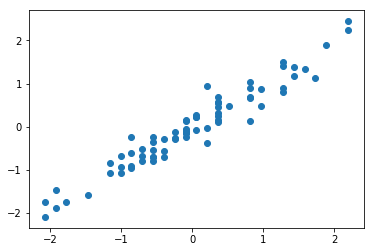

In [11]:
on_normalzied_data_mse = mean_squared_error(normalized_Y_test, on_normalzied_data_y_hat)
on_normalzied_data_mae = mean_absolute_error(normalized_Y_test, on_normalzied_data_y_hat)
plt.scatter(normalized_Y_test, on_normalzied_data_y_hat)
print("MSE : ", on_normalzied_data_mse)
print("MAE : ", on_normalzied_data_mae)

### Linear Model 2

Training and fitting a Linear Regression model on the actual team data, named `selected_cols_raw_all_teams` (includes train and test data)

In [12]:
## Train on raw data
on_raw_data_model = LinearRegression()

## Grab the raw training data
on_raw_X_train = selected_cols_raw_train[training_columns_wanted]
on_raw_Y_train = selected_cols_raw_train["wins"]

## Grab the raw testing data
on_raw_X_test = selected_cols_raw_test[training_columns_wanted]
on_raw_Y_test = selected_cols_raw_test["wins"]

## Fit to raw training data
on_raw_data_model.fit(on_raw_X_train, on_raw_Y_train)

## Predcit of normalized testing data
on_raw_data_y_hat = on_raw_data_model.predict(on_raw_X_test)


MSE :  2.8145010630188527
MAE :  1.335776218552554


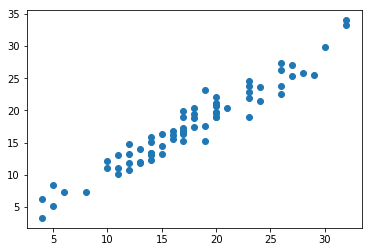

In [13]:
on_raw_data_mse = mean_squared_error(on_raw_Y_test, on_raw_data_y_hat)
on_raw_data_mae = mean_absolute_error(on_raw_Y_test, on_raw_data_y_hat)
plt.scatter(on_raw_Y_test, on_raw_data_y_hat)
print("MSE : ", on_raw_data_mse)
print("MAE : ", on_raw_data_mae)

### Linear Model 3

Training and fitting a Linear Regression model on the actual team data, named `selected_cols_raw_all_teams` (includes train and test data) weighted by the `correlation` to win percentage.

1. Find Correlation weights of desired attributes and wins
2. Multiply coefficients to the training data

## --This achieves perfection--. WE SEE THE LIGHT

By weighing the attributes by their correspondinig correlation to wins, we ensure eliminate errors between the predicted and actual wins values. 

The reason being is that not all attributes are weighed equally. They are weighed by their correlation. 

Intuitively, this makes sense because `points` are much more important than `turnovers` when trying to win a game. This is a simple example, but this is across all attributes, as listed in `attributes_for_correlation`.


## UPDATE: WE DO NOT SEE THE LIGHT

Multiplying by the correlations simply makes the model a scaled version of `Linear Model 1` from above. Because it is simply a scalar multiple (multiple from the coefficients), there is no difference.

In [14]:
attributes_for_correlation = ['assists', 'blocks', 'field_goal_percentage', 'free_throw_percentage',
       'free_throw_attempts', 'net_rating', 'offensive_rating',
       'offensive_rebounds', 'opp_assists', 'opp_field_goal_percentage',
       'opp_offensive_rating', 'opp_three_point_field_goal_percentage', 'pace',
       'points', 'three_point_field_goal_percentage',
       'three_point_field_goal_attempts', 'total_rebounds',
       'true_shooting_percentage', 'turnovers', 'turnover_percentage',
       'two_point_field_goal_percentage']

def correlation(t, x, y):
    ## ENSURE T IS ALREADY IN STD UNITS
    return np.mean(t[x]*t[y])

## Grab all normalized teams
correlation_normalized_all_teams = normalized_all_teams.copy()

## Grab the normalized training data
correlation_normalized_X_train = normalized_train.copy() ## Should already have no strings in data and includes wins/wins percentage
correlation_normalized_train_mean = normalized_train_mean
correlation_normalized_train_std = normalized_train_std 
correlation_normalized_Y_train = correlation_normalized_X_train['wins']

## Grab the normalized testing data
correlation_normalized_X_test = normalized_test.copy()
correlation_normalized_test_mean = normalized_test_mean
correlation_normalized_test_std = normalized_test_std 
correlation_normalized_Y_test = correlation_normalized_X_test['wins']


## Modify the train and tet by the corresponding correlations and map to dictionary
## scaled_mapping is the correlations between each attribute and number of wins
train_correlation_mapping = {}
test_correlation_mapping = {}
all_correlation_mapping = {}

train_scales = []
test_scales = []
all_scales = []

# print("Before correlation weighing")
# print("train mapping: ")
# display(correlation_normalized_X_train)
#
# print("test mapping: ")
# display(correlation_normalized_X_test)
#
# print("all mapping: ")
# display(correlation_normalized_all_teams)

## With normalize data, multiply correlations to their corresponding columns to indicate how important that feature is
for att in attributes_for_correlation:
    ## calclate correlations
    att_train_correlation = correlation(correlation_normalized_X_train, att, 'wins')
    att_test_correlation = correlation(correlation_normalized_X_test, att, 'wins')
    att_all_correlation = correlation(correlation_normalized_all_teams, att, 'wins')
    
    # Retaining correlation
    train_scales.append(att_train_correlation)
    test_scales.append(att_test_correlation)
    all_scales.append(att_all_correlation)
    
    train_correlation_mapping[att] = att_train_correlation
    test_correlation_mapping[att] = att_test_correlation
    all_correlation_mapping[att] = att_all_correlation
    
    ## Scale normal data by correlation. Must multiple by the `att_train_correlation` bc that is what we have access to on new data
    correlation_normalized_X_train[att] = correlation_normalized_X_train[att] * att_train_correlation
    correlation_normalized_X_test[att] = correlation_normalized_X_test[att] * att_train_correlation
    correlation_normalized_all_teams[att] = correlation_normalized_all_teams[att] * att_train_correlation

# print("`correlation_normalized_X_test` now is a weighed version of the normalized data based on correlations with the wins")
# print("After correlation weighing")
# print("train mapping: ")
# display(correlation_normalized_X_train)
#
# print("test mapping: ")
# display(correlation_normalized_X_test)
#
# print("all mapping: ")
# display(correlation_normalized_all_teams)



# display(correlation_all_team)

In [15]:
correlated_model = LinearRegression()

## Fit to correlated normalized data
correlation_normalized_X_train_to_fit = correlation_normalized_X_train[training_columns_wanted]
correlated_model.fit(correlation_normalized_X_train_to_fit, correlation_normalized_Y_train)

## Predict using the correlated normalized linear regression
# correlated_X_predict = correlation_all_team_test[training_columns_wanted]

correlation_normalized_X_test_to_predict = correlation_normalized_X_test[training_columns_wanted]
correlated__normalized_y_hat = correlated_model.predict(correlation_normalized_X_test_to_predict)

## Normalized the test data
# correlated_y_true, correlated_test_mean, correlated_test_std = normalize_data(correlation_normalized_all_test)
# correlated_y_true = correlation_normalized_all_test['wins']



MSE :  0.06738134638921389
MAE :  0.19696531591908123


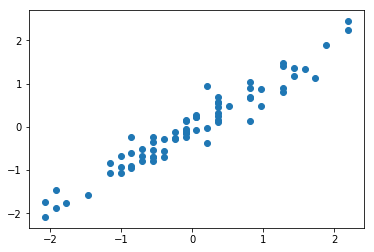

In [16]:
correlated_normal_mse = mean_squared_error(correlation_normalized_Y_test, correlated__normalized_y_hat)
correlated_normal_mae = mean_absolute_error(correlation_normalized_Y_test, correlated__normalized_y_hat)
plt.scatter(correlation_normalized_Y_test, correlated__normalized_y_hat)
print("MSE : ", correlated_normal_mse)
print("MAE : ", correlated_normal_mae)

In [17]:
## See the correlations for the different split data sets
print("train mapping: ")
display(train_correlation_mapping)
print()

print("test mapping: ")
display(test_correlation_mapping)
print()

print("all mapping: ")
display(all_correlation_mapping)

train mapping: 


{'assists': 0.6654546773081536,
 'blocks': 0.4304641490186445,
 'field_goal_percentage': 0.5963255195413198,
 'free_throw_percentage': 0.23421963935215756,
 'free_throw_attempts': 0.4139101598544424,
 'net_rating': 0.9217004602429494,
 'offensive_rating': 0.7500437280350924,
 'offensive_rebounds': 0.35095667225164806,
 'opp_assists': -0.20925221114385645,
 'opp_field_goal_percentage': -0.6565483639374947,
 'opp_offensive_rating': -0.7371774574611148,
 'opp_three_point_field_goal_percentage': -0.5273153805833306,
 'pace': -0.07982569938965109,
 'points': 0.7768729428324928,
 'three_point_field_goal_percentage': 0.35159642388772355,
 'three_point_field_goal_attempts': 0.34647348128296296,
 'total_rebounds': 0.6619112170883134,
 'true_shooting_percentage': 0.5958467095377064,
 'turnovers': -0.05251998544403762,
 'turnover_percentage': -0.4588049076171413,
 'two_point_field_goal_percentage': 0.5604765382325105}


test mapping: 


{'assists': 0.6776929061123911,
 'blocks': 0.6305637715096771,
 'field_goal_percentage': 0.5120673925232795,
 'free_throw_percentage': 0.21294588972266967,
 'free_throw_attempts': 0.5365409418759675,
 'net_rating': 0.9327591991466493,
 'offensive_rating': 0.758367702542355,
 'offensive_rebounds': 0.43373118004788247,
 'opp_assists': -0.15942962411767816,
 'opp_field_goal_percentage': -0.5812552510040606,
 'opp_offensive_rating': -0.7122691333033719,
 'opp_three_point_field_goal_percentage': -0.44651386942221744,
 'pace': 0.07082545697247622,
 'points': 0.8064626904080393,
 'three_point_field_goal_percentage': 0.3122194768762396,
 'three_point_field_goal_attempts': 0.47846458828555377,
 'total_rebounds': 0.7516673771014393,
 'true_shooting_percentage': 0.5295923027015595,
 'turnovers': -0.1556021494241064,
 'turnover_percentage': -0.6237347520874033,
 'two_point_field_goal_percentage': 0.5127870561487065}


all mapping: 


{'assists': 0.6705947017499697,
 'blocks': 0.48189402450975616,
 'field_goal_percentage': 0.5801088857202532,
 'free_throw_percentage': 0.2289690124206667,
 'free_throw_attempts': 0.4404334844337297,
 'net_rating': 0.9263304849912313,
 'offensive_rating': 0.7536334800751393,
 'offensive_rebounds': 0.36909060792366355,
 'opp_assists': -0.19961745371638243,
 'opp_field_goal_percentage': -0.6416795087442887,
 'opp_offensive_rating': -0.7340902442819183,
 'opp_three_point_field_goal_percentage': -0.5106148625472117,
 'pace': -0.051477878960740395,
 'points': 0.7857840651915943,
 'three_point_field_goal_percentage': 0.34566939748072845,
 'three_point_field_goal_attempts': 0.3789045482878669,
 'total_rebounds': 0.6835361690178334,
 'true_shooting_percentage': 0.5833263287053966,
 'turnovers': -0.0708117218469224,
 'turnover_percentage': -0.4954833629183635,
 'two_point_field_goal_percentage': 0.5511366076701941}

In [18]:
## Take a look at the correlation
correlation_normalized_all_teams

,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
ABILENE-CHRISTIAN,0.774246,-0.222930,0.635285,0.036982,0.039896,-1.755243,1.388112,0.633615,-0.025106,0.303351,...,0.304211,0.504627,-0.243210,-0.323315,0.523014,0.020971,0.179612,0.181399,1.552489,1.666118
AIR-FORCE,-0.085929,-0.683878,0.219952,-0.182422,-0.515135,0.416716,-0.711798,-0.532514,-0.435727,-0.043816,...,-0.660275,-0.216962,-0.090169,-0.502526,-0.008916,0.003778,-0.316540,0.471996,-0.490049,-0.438075
AKRON,-0.416766,-0.056476,-0.830598,-0.008190,-0.371386,0.021815,0.590146,-0.455626,-0.099246,0.355227,...,-0.385561,-0.344301,0.564008,0.187165,-0.585173,0.041388,0.310178,-0.245949,-0.018694,0.017045
ALABAMA-AM,-0.549100,-0.773507,-0.879461,-0.511527,-0.714787,2.193774,-1.824750,-1.916490,-0.087840,-0.007902,...,-1.379907,-0.415045,-0.489277,-0.746905,-1.383068,-0.064996,-0.838805,-0.946800,-1.904113,-2.104879
ALABAMA-BIRMINGHAM,-0.397861,-0.363775,0.219952,-0.214687,-0.008020,-0.175636,0.285659,0.197918,0.214422,-0.047806,...,0.208658,-0.103771,-0.141183,0.594463,-0.119734,0.029568,0.362405,0.130117,0.452661,0.348042
ALABAMA-STATE,-1.229678,-0.107693,-0.952755,-0.350201,0.207604,0.614167,-0.890290,-0.993839,0.203016,0.024022,...,-0.937976,-0.330152,-0.204200,-0.410205,-0.939793,-0.026311,-0.420993,-0.861330,-0.804285,-0.739518
ALABAMA,-0.237169,0.634947,-0.073225,-0.259858,0.427221,0.021815,-0.092325,-0.109632,0.311374,0.191620,...,0.142965,-0.061325,-0.069163,0.627046,-0.186226,-0.041355,-0.159860,-0.109198,0.138424,0.099795
ALBANY-NY,-0.388408,-0.414992,-0.659578,0.249932,-0.271560,0.811618,-0.491308,-0.570957,-0.201901,-0.119634,...,-0.746870,0.037717,0.146895,-0.480804,-0.186226,-0.029534,-0.577673,-0.553640,-0.804285,-0.810446
ALCORN-STATE,-0.492386,-0.043672,-0.757304,-0.208234,-0.355414,1.009069,-1.142280,-1.339833,0.026221,-0.227375,...,-1.209704,-0.245259,-0.285221,-0.491665,-0.828974,-0.070369,-0.969371,-0.724579,-1.118522,-1.117800


## Conclusion for Model Selection

Model 1 and 3 are the same, using the normalized versions of the data and provide nearly 0 mse and mae when predicting team wins based on team stats

# After Developing Model, create the demand vector

Create comparisons of all the teams compared to the top `optimal_baseline_percentage` of the entire NCAAB league.

In order to find the actual demand vector, we first use the `normalized data`. Because the normalized data is in standard units which can be negative, we add the minimum of every attribute to all attributes so that we have purly positive values in the demand vector. Then, each attribute is multiplied by their correlation(if it exists).

These multipled positive values are what we will call the `demand vector` for any particular team, because it sohws which team attribute is in demand for any particular team.

In [30]:
# select top 5% teams as optimal
optimal_baseline_percentage = .05
num_of_teams_in_optimal_baseline = int(optimal_baseline_percentage * normalized_all_teams.shape[0])

## Pick out the summary stats for the of 5% of teams
normalized_top_5 = normalized_all_teams.iloc[:num_of_teams_in_optimal_baseline]
normalized_non_string_top_5 = get_desired_columns_from_df(normalized_top_5, team_columns_wanted_without_strings)

normalized_top_5_desc = normalized_non_string_top_5.describe()
normalized_top_5_mean = normalized_top_5_desc.loc['mean']
normalized_top_5_std = normalized_top_5_desc.loc['std']


normalized_non_string_all_teams = get_desired_columns_from_df(normalized_all_teams, team_columns_wanted_without_strings)
normalized_all_teams_min = normalized_non_string_all_teams.describe().loc['min']

normalized_non_string_all_teams = get_desired_columns_from_df(normalized_all_teams, team_columns_wanted_without_strings)


demeaned_normalized_comparison_stats = normalized_non_string_all_teams - normalized_top_5_mean
demeaned_normalized_comparison_stats

,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
ABILENE-CHRISTIAN,1.569183,-0.286951,1.289347,0.685539,-0.042561,-2.055811,1.753621,1.291435,-0.015294,-1.205893,...,0.801061,1.697248,-0.308740,-0.223934,1.207810,-0.681214,-0.873825,0.557951,1.885420e+00,1.980069
AIR-FORCE,0.276571,-1.357769,0.592859,-0.251202,-1.383507,0.116148,-0.524679,-0.263312,-1.185297,0.453191,...,-0.440437,-0.355073,0.132972,-0.494682,0.315081,-0.353846,0.207575,1.076432,-1.571183e-01,-0.124124
AKRON,-0.220588,0.099733,-1.168847,0.492681,-1.036212,-0.278754,0.887867,-0.160801,-0.226545,-1.453802,...,-0.086821,-0.717247,2.021072,0.547287,-0.652043,-1.069964,-1.158404,-0.204522,3.142366e-01,0.330997
ALABAMA-AM,-0.419452,-1.565983,-1.250787,-1.656315,-1.865862,1.893205,-1.732178,-2.108506,-0.194045,0.281562,...,-1.366756,-0.918455,-1.018942,-0.863884,-1.991137,0.955626,1.345892,-1.454978,-1.571183e+00,-1.790928
ALABAMA-BIRMINGHAM,-0.192179,-0.614145,0.592859,-0.388958,-0.158326,-0.476205,0.557513,0.710541,0.667208,0.472261,...,0.678065,-0.033140,-0.014265,1.162623,0.129096,-0.844898,-1.272236,0.466454,7.855915e-01,0.661993
ALABAMA-STATE,-1.442178,-0.019247,-1.373697,-0.967534,0.362617,0.313598,-0.718335,-0.878377,0.634708,0.129002,...,-0.797896,-0.677005,-0.196146,-0.355206,-1.247196,0.219048,0.435239,-1.302483,-4.713549e-01,-0.425567
ALABAMA,0.049298,1.705960,0.101220,-0.581817,0.893208,-0.278754,0.147419,0.300497,0.943458,-0.671935,...,0.593504,0.087585,0.193599,1.211850,0.017504,0.505495,-0.133920,0.039469,4.713549e-01,0.413746
ALBANY-NY,-0.177974,-0.733125,-0.882058,1.594730,-0.795034,0.511049,-0.285458,-0.314567,-0.519045,0.815520,...,-0.551902,0.369276,0.817192,-0.461864,0.017504,0.280429,0.776733,-0.753503,-4.713549e-01,-0.496495
ALCORN-STATE,-0.334224,0.129478,-1.045937,-0.361407,-0.997624,0.708500,-0.991730,-1.339675,0.130956,1.330408,...,-1.147668,-0.435556,-0.429994,-0.478273,-1.061210,1.057928,1.630471,-1.058492,-7.855915e-01,-0.803849


In [144]:
'''
Finds the demand vector by shifting the team's values by the min of all teams
then multiplying attributes by their corresponding correlation to wins, via the `all_correlation_mapping`.

The demand vector is in standard units and indicates where the team sits along the normal curve for a team attribute.
@param single_team_demeaned_raw_comparison_stats: must be normalized
@param all_correlation_mapping: must be a mapping from an attribute to a value [-1,1]
@param normalized_min_att_all_teams: must be the minimum normalized values for among all teams 
'''
def find_demand_vector(single_team_demeaned_normalized_comparison_stats, all_correlation_mapping, normalized_min_att_all_teams):
    ## Shift to ensure values are positive (add the minimum)
    shifted_team_demeaned_NCS = single_team_demeaned_normalized_comparison_stats.copy()
    shifted_team_demeaned_NCS = shifted_team_demeaned_NCS + abs(normalized_min_att_all_teams)
    
    ## Multiply the attributes by their corresponding weights and set to the team's new value
    for att in all_correlation_mapping.keys():
        team_att_value = shifted_team_demeaned_NCS[att] * all_correlation_mapping[att]
        shifted_team_demeaned_NCS[att] = team_att_value
    
    return shifted_team_demeaned_NCS

## To determine which team attribute(of the minimizing attributes) needs to improve,
## we take the maximum since we are trying to minimize these attributes.
## The more negative, the better the team is in the particular attribute already.
## Thus we want the descending order to reveal which is the attribute for most improvement.
## The values indicates where the team sits in terms of the normal bell curve.
def sort_min_in_demand_vector(demand_vector, minimizing_attributes):
    demand_options = get_desired_columns_from_df(demand_vector, minimizing_attributes)
    return demand_options.sort_values(axis=0, ascending=False)
    
## To determine which team attribute(of the maximizing attributes) needs to improve,
## we take the minimum since we are trying to maximize these attributes.
## The more positive, the better the team is in the particular attribute already. 
## Thus we want the ascending order to reveal which attribute needs the most improvement.
## The values indicates where the team sits in terms of the normal bell curve.
def sort_max_in_demand_vector(demand_vector, minimizing_attributes):
    demand_options = get_desired_columns_from_df(demand_vector, minimizing_attributes)
    return demand_options.sort_values(axis=0, ascending=True)
    

## Interpretation of the Demand Vector
The `demand_vector` indicates the team's ranking(in standard units) on how correlated a specific attribute is to winning. 

For some attributes, a team was to be in the upper half of the normal curve (i.e. assists, points, blocks, three point percentage).

Meanwhile, for other attributes, a team was to be in the lower half of the normal curve (i.e. turnovers, opp_assists, opp_offensive rating, etc.).

So we will split these attributes into two groups, `maximizing_att` and `minimizing_att`. These two are complement sets of all the attributes we look at

`maximizing_att` may indicates what type of offensive strategy to use.

`minimizing_att` may indicates what type of defensive strategy to use

In [145]:
all_attributes = demeaned_normalized_comparison_stats.columns
all_attributes 
## Indicates what type of offensive strategy to use
maximizing_att = ['assists', 'blocks', 'field_goal_percentage', 'free_throw_percentage',
       'free_throw_attempts', 'net_rating', 'offensive_rating',
       'offensive_rebounds', 'pace',
       'points', 'three_point_field_goal_percentage',
       'three_point_field_goal_attempts', 'total_rebounds',
       'true_shooting_percentage', 
       'two_point_field_goal_percentage', 'wins', 'win_percentage']

## Indicates what type of defensive strategy to use
minimizing_att = ['losses', 'opp_assists', 'opp_field_goal_percentage',
       'opp_offensive_rating', 'opp_three_point_field_goal_percentage', 
        'turnovers', 'turnover_percentage']

## Ensure maximizing_att and minimizing_att are complements.
print(len(all_attributes), " should equal ", (len(maximizing_att) + len(minimizing_att)))

24  should equal  24


### Example on ALABAMA-AM

In [156]:
AC = demeaned_normalized_comparison_stats.loc['ALABAMA-AM']
AC_demand_vec = find_demand_vector(AC, all_correlation_mapping, normalized_all_teams_min)

AC_min_sorted = sort_min_in_demand_vector(AC_demand_vec, minimizing_att)
AC_max_sorted = sort_max_in_demand_vector(AC_demand_vec, maximizing_att)
# normalized_non_string_top_5.describe()
print("ALABAMA-AM in in the top 5% of teams. This is their normalized team stats.")
display(AC)

print("This is ALABAMA-AM's normalized demand vector.")
display(AC_demand_vec)
# print(AC_min_index, " with val: " , AC_min_val)
# print(AC_max_index, " with val: " , AC_max_val)
print("mins here:")
print(AC_min_sorted)
print()
print("max here:")
print(AC_max_sorted)

ALABAMA-AM in in the top 5% of teams. This is their normalized team stats.


assists                                 -0.419452
blocks                                  -1.565983
field_goal_percentage                   -1.250787
free_throw_percentage                   -1.656315
free_throw_attempts                     -1.865862
losses                                   1.893205
net_rating                              -1.732178
offensive_rating                        -2.108506
offensive_rebounds                      -0.194045
opp_assists                              0.281562
opp_field_goal_percentage                1.302730
opp_offensive_rating                     0.565200
opp_three_point_field_goal_percentage    0.702167
pace                                    -0.601849
points                                  -1.366756
three_point_field_goal_percentage       -0.918455
three_point_field_goal_attempts         -1.018942
total_rebounds                          -0.863884
true_shooting_percentage                -1.991137
turnovers                                0.955626


This is ALABAMA-AM's normalized demand vector.


assists                                  1.196032
blocks                                   0.168620
field_goal_percentage                    1.389603
free_throw_percentage                    0.392075
free_throw_attempts                      0.261719
losses                                   4.438251
net_rating                               1.949371
offensive_rating                         0.748651
offensive_rebounds                       0.902426
opp_assists                             -0.604444
opp_field_goal_percentage               -2.821214
opp_offensive_rating                    -2.540527
opp_three_point_field_goal_percentage   -1.777525
pace                                    -0.125822
points                                   0.913735
three_point_field_goal_percentage        0.577426
three_point_field_goal_attempts          0.608430
total_rebounds                           1.229518
true_shooting_percentage                 0.908558
turnovers                               -0.245175


mins here:
losses                                   4.438251
turnovers                               -0.245175
opp_assists                             -0.604444
opp_three_point_field_goal_percentage   -1.777525
turnover_percentage                     -1.876068
opp_offensive_rating                    -2.540527
opp_field_goal_percentage               -2.821214
dtype: float64

max here:
pace                                -0.125822
blocks                               0.168620
free_throw_attempts                  0.261719
free_throw_percentage                0.392075
three_point_field_goal_percentage    0.577426
three_point_field_goal_attempts      0.608430
wins                                 0.647167
win_percentage                       0.680412
offensive_rating                     0.748651
offensive_rebounds                   0.902426
true_shooting_percentage             0.908558
points                               0.913735
two_point_field_goal_percentage      1.087248
assists        

In [157]:
### Another Example of CALIFORNIA (UC Berkeley)
cal = demeaned_normalized_comparison_stats.loc['CALIFORNIA']
cal_demand_vec = find_demand_vector(cal, all_correlation_mapping, normalized_all_teams_min)

cal_min_sorted = sort_min_in_demand_vector(cal_demand_vec, minimizing_att)
cal_max_sorted = sort_max_in_demand_vector(cal_demand_vec, maximizing_att)
# normalized_non_string_top_5.describe()
print("CAL's normalized team stats.")
display(cal)

print("This is CAL's normalized demand vector.")
display(cal_demand_vec)
# print(AC_min_index, " with val: " , AC_min_val)
# print(AC_max_index, " with val: " , AC_max_val)
print("mins here:")
print(cal_min_sorted)
print()
print("max here:")
print(cal_max_sorted)

CAL's normalized team stats.


assists                                 -1.087065
blocks                                  -0.108482
field_goal_percentage                   -0.472359
free_throw_percentage                    0.988603
free_throw_attempts                     -0.418798
losses                                   1.103402
net_rating                              -1.356258
offensive_rating                        -0.263312
offensive_rebounds                      -1.250297
opp_assists                              0.815520
opp_field_goal_percentage                2.195730
opp_offensive_rating                     2.044934
opp_three_point_field_goal_percentage    1.935494
pace                                    -0.249041
points                                  -0.663368
three_point_field_goal_percentage        0.490000
three_point_field_goal_attempts         -0.897688
total_rebounds                          -1.946875
true_shooting_percentage                -0.280072
turnovers                               -1.806541


This is CAL's normalized demand vector.


assists                                  0.748334
blocks                                   0.870981
field_goal_percentage                    1.841176
free_throw_percentage                    0.997679
free_throw_attempts                      0.899055
losses                                   3.648448
net_rating                               2.297597
offensive_rating                         2.139251
offensive_rebounds                       0.512573
opp_assists                             -0.711031
opp_field_goal_percentage               -3.394233
opp_offensive_rating                    -3.626785
opp_three_point_field_goal_percentage   -2.407280
pace                                    -0.143984
points                                   1.466446
three_point_field_goal_percentage        1.064286
three_point_field_goal_attempts          0.654374
total_rebounds                           0.489254
true_shooting_percentage                 1.906667
turnovers                               -0.049582


mins here:
losses                                   3.648448
turnovers                               -0.049582
turnover_percentage                     -0.578829
opp_assists                             -0.711031
opp_three_point_field_goal_percentage   -2.407280
opp_field_goal_percentage               -3.394233
opp_offensive_rating                    -3.626785
dtype: float64

max here:
pace                                -0.143984
total_rebounds                       0.489254
offensive_rebounds                   0.512573
three_point_field_goal_attempts      0.654374
assists                              0.748334
blocks                               0.870981
free_throw_attempts                  0.899055
free_throw_percentage                0.997679
three_point_field_goal_percentage    1.064286
wins                                 1.118522
win_percentage                       1.283298
two_point_field_goal_percentage      1.339384
points                               1.466446
field_goal_perc

### Interpretation
From `AC_min_sorted` for `ALABAMA-AM`, we see that they need to improve on a number of things.

Starting from the max_sorted demand vector, we see that their net rating is 1.94 standard units above the mean, which means they are very good. Meanwhile, their pace is slightly below average, so they need to improve their pace. Other ways they can improve is the number of blocks and free throws/3point shooting. 

From the min_sorted demand vector, we see that they have many many losses, specifically 4.4 stand units above the mean i nthe NCAA league. However, losses is not actionable, so we look at the next attribute, which is turnovers. Their turnovers are slightly less than average, so that's okay. Since most of their min values are negative, they are already better than average, since for these attributes, they are solid. This indicates their defense is solid and that they need bettter offense.

Overall, we see that `ALABAMA-AM` is for the most part, a solid defensive team but are not offensively strong enough. From here, we would recommend a strong offensive player.

A similar analysis can be done for `CAL`

However, in order to onboard a player, the team may need to cut someone. Who should they cut? 

The person who contributes the least to the team averages and has a decent playing time. 

# Finding and Ridding the worst player

After creating the demand vector for the team, we now know have quantified where the team sits offensively and defensively relative to all other teams.



In [290]:
all_players_indexed = all_players.copy()
all_players_indexed = all_players_indexed.set_index(['_season', '_team_abbreviation', '_position', '_player_id'])


In [291]:
# all_players[all_players['_team_abbreviation']=='california']
all_players_indexed_columns = all_players_indexed.columns
print(all_players_indexed_columns)
display(all_players_indexed)

Index(['Unnamed: 0', '_name', '_height', '_weight', '_minutes_played',
       '_total_rebounds', '_player_efficiency_rating',
       '_field_goal_percentage', '_free_throw_percentage',
       '_two_point_percentage', '_three_point_percentage',
       '_offensive_rebounds', '_assists', '_turnovers', '_usage_percentage',
       '_offensive_win_shares', '_defensive_rebounds', '_steals', '_blocks',
       '_defensive_win_shares'],
      dtype='object')


Unnamed: 0  \
_season _team_abbreviation _position     _player_id                                   
2018-19 abilene-christian  Guard-Forward jaren-lewis-1                jaren-lewis-1   
                           Guard         payten-ricks-1              payten-ricks-1   
                                         jaylen-franklin-1        jaylen-franklin-1   
                           Center        jalone-friday-1            jalone-friday-1   
                           Forward       hayden-farquhar-1        hayden-farquhar-1   
                           Guard         bj-maxwell-1                  bj-maxwell-1   
                           Forward       joe-pleasant-1              joe-pleasant-1   
                           Guard         damien-daniels-1          damien-daniels-1   
                                         trey-lenox-1                  trey-lenox-1   
                           Forward       clay-gayman-1                clay-gayman-1   
                           Center        kolton-kohl-1                kolton-kohl-1   
                           Guard         tobias-cameron-1          tobias-cameron-1   
                                         chase-cobb-1                  chase-cobb-1   
                                         paul-hiepler-1              paul-hiepler-1   
        air-force          Forward       lavelle-scottie-1        lavelle-scottie-1   
                                         ryan-swan-ford-1          ryan-swan-ford-1   
                           Guard         aj-walker-1                    aj-walker-1   
                                         christopher-joyce-1    christopher-joyce-1   
                                         caleb-morris-1              caleb-morris-1   
                                         sid-tomes-1                    sid-tomes-1   
                                         keaton-vansoelen-1      keaton-vansoelen-1   
                           Forward       ameka-akaya-1                ameka-akaya-1   
                           Guard         pervis-louder-1            pervis-louder-1   
                                         lesean-brown-1              lesean-brown-1   
                           Forward       abe-kinrade-1                abe-kinrade-1   
                           Guard         bryce-hughes-1              bryce-hughes-1   
                           Forward       charles-obriant-1        charles-obriant-1   
                           Guard         zach-couper-1                zach-couper-1   
                                         james-edwards-4            james-edwards-4   
                                         nick-rene-1                    nick-rene-1   
...                                                                             ...   
        yale               Forward       paul-atkinson-1            paul-atkinson-1   
                           Guard         azar-swain-1                  azar-swain-1   
                                         trey-phills-1                trey-phills-1   
                                         eric-monroe-1                eric-monroe-1   
                           Forward       austin-williams-3        austin-williams-3   
                                         isaiah-kelly-1              isaiah-kelly-1   
                           Guard         jalen-gabbidon-1          jalen-gabbidon-1   
                                         matthue-cotton-1          matthue-cotton-1   
                           Forward       jameel-alausa-1            jameel-alausa-1   
                           Guard         eze-dike-1                      eze-dike-1   
                           Forward-Guard thomas-ryan-1                thomas-ryan-1   
                           Forward       wyatt-yess-1                  wyatt-yess-1   
                           Guard         michael-feinberg-1      michael-feinberg-1   
                           Forward       jake-lanford-1              ja

In [292]:
## For parsing through height
h_reg = re.compile(r"([0-9]+)-([0-9]+)")
def parse_ht(ht):
    print(ht, type(ht))
    # format: 7-0
    if (type(ht)!=str):
        return str(ht)
    
    ht_ = ht.split('-')
    ft_ = float(ht_[0])
    in_ = float(ht_[1])
    return (12*ft_) + in_

w_reg = re.compile(r"([0-9]+)lb")
def clean_weight(el):
    print(el, type(el))
    # format: 210lb
    if (type(el)!=str):
        return str(el)
    m = w_reg.match(el)
    if m == None:
        return float('NaN')
    else:
        return int(m.group(1))

In [293]:
player_columns_wanted = ['_name', '_height', '_weight', '_minutes_played',
       '_total_rebounds', '_player_efficiency_rating',
       '_field_goal_percentage', '_free_throw_percentage',
       '_two_point_percentage', '_three_point_percentage',
       '_offensive_rebounds', '_assists', '_turnovers', '_usage_percentage',
       '_offensive_win_shares', '_defensive_rebounds', '_steals', '_blocks',
       '_defensive_win_shares']

player_columns_wanted_without_strings = player_columns_wanted[2:]

## Clean heigh and weight to quantities
all_players_indexed["_height"] = all_players_indexed["_height"].apply(lambda x:parse_ht(x))
all_players_indexed["_weight"] = all_players_indexed["_weight"].apply(lambda x:clean_weight(x))
all_players_indexed

# ## Create a copy of the normalized raw all teams
# selected_cols_raw_all_players = get_desired_columns_from_df(all_players_indexed, player_columns_wanted_without_strings)
# normalized_all_players, normalized_all_players_mean, normalized_all_players_std = normalize_data(selected_cols_raw_all_players)
# print("Normalized all teams")
# display(normalized_all_teams)



6-6 <class 'str'>
6-2 <class 'str'>
6-2 <class 'str'>
6-9 <class 'str'>
6-7 <class 'str'>
6-5 <class 'str'>
6-8 <class 'str'>
5-7 <class 'str'>
6-3 <class 'str'>
6-6 <class 'str'>
7-0 <class 'str'>
6-5 <class 'str'>
6-1 <class 'str'>
6-4 <class 'str'>
6-7 <class 'str'>
6-7 <class 'str'>
6-2 <class 'str'>
6-5 <class 'str'>
6-4 <class 'str'>
6-4 <class 'str'>
6-7 <class 'str'>
6-6 <class 'str'>
6-4 <class 'str'>
6-2 <class 'str'>
6-7 <class 'str'>
6-4 <class 'str'>
6-8 <class 'str'>
6-4 <class 'str'>
6-0 <class 'str'>
6-0 <class 'str'>
6-9 <class 'str'>
6-6 <class 'str'>
5-8 <class 'str'>
6-5 <class 'str'>
6-5 <class 'str'>
6-4 <class 'str'>
6-10 <class 'str'>
6-2 <class 'str'>
6-8 <class 'str'>
6-9 <class 'str'>
6-11 <class 'str'>
5-10 <class 'str'>
6-6 <class 'str'>
6-4 <class 'str'>
5-10 <class 'str'>
6-7 <class 'str'>
6-5 <class 'str'>
6-8 <class 'str'>
6-0 <class 'str'>
5-11 <class 'str'>
6-6 <class 'str'>
6-2 <class 'str'>
6-5 <class 'str'>
6-7 <class 'str'>
6-2 <class 'str'>
5-9 <

6-3 <class 'str'>
6-7 <class 'str'>
5-10 <class 'str'>
6-1 <class 'str'>
6-5 <class 'str'>
6-10 <class 'str'>
6-0 <class 'str'>
6-8 <class 'str'>
6-5 <class 'str'>
6-3 <class 'str'>
6-9 <class 'str'>
6-8 <class 'str'>
6-2 <class 'str'>
6-3 <class 'str'>
6-6 <class 'str'>
6-8 <class 'str'>
6-3 <class 'str'>
6-7 <class 'str'>
6-2 <class 'str'>
6-1 <class 'str'>
6-7 <class 'str'>
6-4 <class 'str'>
6-0 <class 'str'>
6-9 <class 'str'>
6-10 <class 'str'>
6-9 <class 'str'>
6-9 <class 'str'>
6-5 <class 'str'>
6-8 <class 'str'>
6-2 <class 'str'>
5-11 <class 'str'>
6-11 <class 'str'>
6-3 <class 'str'>
6-2 <class 'str'>
5-10 <class 'str'>
6-6 <class 'str'>
6-6 <class 'str'>
6-0 <class 'str'>
6-7 <class 'str'>
6-9 <class 'str'>
6-4 <class 'str'>
6-9 <class 'str'>
6-3 <class 'str'>
6-7 <class 'str'>
5-11 <class 'str'>
6-7 <class 'str'>
6-0 <class 'str'>
6-2 <class 'str'>
6-7 <class 'str'>
6-10 <class 'str'>
6-8 <class 'str'>
6-4 <class 'str'>
6-5 <class 'str'>
6-7 <class 'str'>
6-4 <class 'str'>
6-

6-6 <class 'str'>
6-0 <class 'str'>
6-7 <class 'str'>
6-9 <class 'str'>
6-5 <class 'str'>
6-2 <class 'str'>
6-8 <class 'str'>
6-11 <class 'str'>
6-10 <class 'str'>
6-3 <class 'str'>
6-5 <class 'str'>
6-6 <class 'str'>
6-8 <class 'str'>
6-0 <class 'str'>
6-6 <class 'str'>
6-10 <class 'str'>
6-3 <class 'str'>
6-0 <class 'str'>
6-0 <class 'str'>
6-9 <class 'str'>
6-8 <class 'str'>
6-3 <class 'str'>
5-9 <class 'str'>
6-3 <class 'str'>
6-3 <class 'str'>
6-6 <class 'str'>
7-0 <class 'str'>
7-0 <class 'str'>
6-2 <class 'str'>
7-0 <class 'str'>
6-5 <class 'str'>
6-4 <class 'str'>
6-0 <class 'str'>
6-3 <class 'str'>
6-5 <class 'str'>
6-7 <class 'str'>
6-5 <class 'str'>
6-2 <class 'str'>
5-11 <class 'str'>
6-8 <class 'str'>
6-4 <class 'str'>
5-11 <class 'str'>
6-4 <class 'str'>
6-4 <class 'str'>
6-8 <class 'str'>
6-10 <class 'str'>
6-2 <class 'str'>
6-5 <class 'str'>
6-0 <class 'str'>
6-10 <class 'str'>
6-4 <class 'str'>
6-1 <class 'str'>
6-8 <class 'str'>
6-8 <class 'str'>
6-4 <class 'str'>
6-7

6-11 <class 'str'>
6-6 <class 'str'>
6-1 <class 'str'>
6-4 <class 'str'>
6-8 <class 'str'>
6-7 <class 'str'>
6-1 <class 'str'>
6-2 <class 'str'>
6-10 <class 'str'>
6-4 <class 'str'>
6-9 <class 'str'>
6-4 <class 'str'>
6-6 <class 'str'>
6-0 <class 'str'>
6-8 <class 'str'>
6-2 <class 'str'>
6-5 <class 'str'>
6-2 <class 'str'>
6-3 <class 'str'>
6-10 <class 'str'>
6-5 <class 'str'>
6-2 <class 'str'>
6-3 <class 'str'>
6-7 <class 'str'>
6-0 <class 'str'>
6-8 <class 'str'>
6-3 <class 'str'>
6-8 <class 'str'>
5-9 <class 'str'>
6-2 <class 'str'>
6-6 <class 'str'>
6-8 <class 'str'>
6-10 <class 'str'>
5-10 <class 'str'>
6-6 <class 'str'>
5-11 <class 'str'>
6-7 <class 'str'>
6-7 <class 'str'>
6-3 <class 'str'>
6-4 <class 'str'>
6-4 <class 'str'>
6-2 <class 'str'>
6-7 <class 'str'>
6-11 <class 'str'>
6-4 <class 'str'>
6-10 <class 'str'>
6-8 <class 'str'>
6-3 <class 'str'>
6-3 <class 'str'>
6-3 <class 'str'>
5-7 <class 'str'>
6-7 <class 'str'>
6-2 <class 'str'>
6-3 <class 'str'>
6-10 <class 'str'>
6

6-6 <class 'str'>
6-11 <class 'str'>
6-6 <class 'str'>
6-7 <class 'str'>
6-4 <class 'str'>
6-8 <class 'str'>
6-8 <class 'str'>
6-5 <class 'str'>
6-7 <class 'str'>
6-3 <class 'str'>
6-11 <class 'str'>
6-4 <class 'str'>
5-11 <class 'str'>
6-4 <class 'str'>
6-8 <class 'str'>
6-9 <class 'str'>
5-9 <class 'str'>
6-3 <class 'str'>
6-3 <class 'str'>
6-10 <class 'str'>
6-9 <class 'str'>
6-1 <class 'str'>
6-6 <class 'str'>
6-3 <class 'str'>
6-3 <class 'str'>
6-3 <class 'str'>
6-8 <class 'str'>
6-5 <class 'str'>
6-5 <class 'str'>
6-9 <class 'str'>
6-1 <class 'str'>
6-0 <class 'str'>
6-5 <class 'str'>
6-8 <class 'str'>
6-4 <class 'str'>
6-9 <class 'str'>
6-8 <class 'str'>
6-7 <class 'str'>
6-3 <class 'str'>
6-2 <class 'str'>
6-7 <class 'str'>
6-5 <class 'str'>
6-7 <class 'str'>
6-5 <class 'str'>
6-5 <class 'str'>
6-2 <class 'str'>
6-1 <class 'str'>
6-7 <class 'str'>
6-6 <class 'str'>
6-4 <class 'str'>
6-4 <class 'str'>
6-10 <class 'str'>
6-4 <class 'str'>
6-2 <class 'str'>
6-1 <class 'str'>
6-9 <

5-11 <class 'str'>
5-10 <class 'str'>
6-2 <class 'str'>
6-9 <class 'str'>
6-4 <class 'str'>
6-2 <class 'str'>
6-5 <class 'str'>
6-1 <class 'str'>
6-7 <class 'str'>
6-7 <class 'str'>
6-4 <class 'str'>
6-1 <class 'str'>
6-5 <class 'str'>
6-8 <class 'str'>
6-10 <class 'str'>
7-2 <class 'str'>
6-2 <class 'str'>
6-3 <class 'str'>
6-6 <class 'str'>
6-5 <class 'str'>
6-3 <class 'str'>
5-11 <class 'str'>
6-5 <class 'str'>
6-5 <class 'str'>
6-11 <class 'str'>
6-8 <class 'str'>
6-1 <class 'str'>
6-2 <class 'str'>
7-0 <class 'str'>
6-4 <class 'str'>
6-7 <class 'str'>
6-6 <class 'str'>
6-6 <class 'str'>
6-8 <class 'str'>
6-5 <class 'str'>
6-5 <class 'str'>
7-2 <class 'str'>
6-10 <class 'str'>
6-3 <class 'str'>
6-10 <class 'str'>
6-9 <class 'str'>
5-10 <class 'str'>
6-0 <class 'str'>
6-6 <class 'str'>
5-8 <class 'str'>
6-2 <class 'str'>
6-3 <class 'str'>
6-4 <class 'str'>
6-8 <class 'str'>
6-4 <class 'str'>
6-7 <class 'str'>
6-10 <class 'str'>
6-7 <class 'str'>
5-10 <class 'str'>
6-10 <class 'str'>

6-6 <class 'str'>
6-8 <class 'str'>
5-11 <class 'str'>
6-0 <class 'str'>
6-5 <class 'str'>
6-1 <class 'str'>
7-0 <class 'str'>
6-7 <class 'str'>
6-4 <class 'str'>
6-5 <class 'str'>
6-8 <class 'str'>
6-10 <class 'str'>
6-0 <class 'str'>
6-1 <class 'str'>
5-10 <class 'str'>
6-4 <class 'str'>
6-7 <class 'str'>
6-11 <class 'str'>
6-2 <class 'str'>
6-5 <class 'str'>
6-6 <class 'str'>
6-3 <class 'str'>
6-10 <class 'str'>
6-8 <class 'str'>
6-4 <class 'str'>
6-7 <class 'str'>
6-1 <class 'str'>
6-11 <class 'str'>
6-9 <class 'str'>
6-2 <class 'str'>
7-0 <class 'str'>
6-1 <class 'str'>
6-5 <class 'str'>
6-5 <class 'str'>
6-4 <class 'str'>
6-1 <class 'str'>
6-6 <class 'str'>
6-3 <class 'str'>
5-11 <class 'str'>
6-5 <class 'str'>
6-6 <class 'str'>
5-11 <class 'str'>
6-8 <class 'str'>
6-0 <class 'str'>
6-11 <class 'str'>
6-5 <class 'str'>
6-3 <class 'str'>
6-4 <class 'str'>
7-0 <class 'str'>
6-2 <class 'str'>
6-9 <class 'str'>
6-8 <class 'str'>
6-6 <class 'str'>
6-6 <class 'str'>
5-11 <class 'str'>


170lb <class 'str'>
215lb <class 'str'>
175lb <class 'str'>
180lb <class 'str'>
160lb <class 'str'>
183lb <class 'str'>
187lb <class 'str'>
225lb <class 'str'>
195lb <class 'str'>
225lb <class 'str'>
225lb <class 'str'>
205lb <class 'str'>
175lb <class 'str'>
210lb <class 'str'>
221lb <class 'str'>
220lb <class 'str'>
186lb <class 'str'>
170lb <class 'str'>
190lb <class 'str'>
235lb <class 'str'>
180lb <class 'str'>
235lb <class 'str'>
220lb <class 'str'>
170lb <class 'str'>
275lb <class 'str'>
217lb <class 'str'>
210lb <class 'str'>
200lb <class 'str'>
200lb <class 'str'>
255lb <class 'str'>
170lb <class 'str'>
230lb <class 'str'>
205lb <class 'str'>
275lb <class 'str'>
210lb <class 'str'>
160lb <class 'str'>
200lb <class 'str'>
210lb <class 'str'>
175lb <class 'str'>
210lb <class 'str'>
205lb <class 'str'>
185lb <class 'str'>
225lb <class 'str'>
190lb <class 'str'>
235lb <class 'str'>
185lb <class 'str'>
190lb <class 'str'>
180lb <class 'str'>
220lb <class 'str'>
230lb <class 'str'>


215lb <class 'str'>
200lb <class 'str'>
170lb <class 'str'>
220lb <class 'str'>
220lb <class 'str'>
185lb <class 'str'>
215lb <class 'str'>
200lb <class 'str'>
250lb <class 'str'>
210lb <class 'str'>
180lb <class 'str'>
225lb <class 'str'>
155lb <class 'str'>
190lb <class 'str'>
190lb <class 'str'>
220lb <class 'str'>
190lb <class 'str'>
175lb <class 'str'>
215lb <class 'str'>
235lb <class 'str'>
215lb <class 'str'>
175lb <class 'str'>
210lb <class 'str'>
205lb <class 'str'>
250lb <class 'str'>
195lb <class 'str'>
200lb <class 'str'>
220lb <class 'str'>
200lb <class 'str'>
170lb <class 'str'>
220lb <class 'str'>
225lb <class 'str'>
200lb <class 'str'>
175lb <class 'str'>
185lb <class 'str'>
210lb <class 'str'>
230lb <class 'str'>
190lb <class 'str'>
170lb <class 'str'>
195lb <class 'str'>
160lb <class 'str'>
195lb <class 'str'>
250lb <class 'str'>
240lb <class 'str'>
185lb <class 'str'>
230lb <class 'str'>
190lb <class 'str'>
190lb <class 'str'>
160lb <class 'str'>
215lb <class 'str'>


210lb <class 'str'>
210lb <class 'str'>
210lb <class 'str'>
210lb <class 'str'>
170lb <class 'str'>
225lb <class 'str'>
215lb <class 'str'>
200lb <class 'str'>
175lb <class 'str'>
235lb <class 'str'>
185lb <class 'str'>
215lb <class 'str'>
195lb <class 'str'>
205lb <class 'str'>
260lb <class 'str'>
190lb <class 'str'>
235lb <class 'str'>
185lb <class 'str'>
245lb <class 'str'>
225lb <class 'str'>
210lb <class 'str'>
190lb <class 'str'>
220lb <class 'str'>
205lb <class 'str'>
170lb <class 'str'>
170lb <class 'str'>
190lb <class 'str'>
230lb <class 'str'>
165lb <class 'str'>
220lb <class 'str'>
210lb <class 'str'>
205lb <class 'str'>
200lb <class 'str'>
225lb <class 'str'>
195lb <class 'str'>
200lb <class 'str'>
215lb <class 'str'>
180lb <class 'str'>
175lb <class 'str'>
180lb <class 'str'>
205lb <class 'str'>
230lb <class 'str'>
193lb <class 'str'>
210lb <class 'str'>
172lb <class 'str'>
220lb <class 'str'>
185lb <class 'str'>
217lb <class 'str'>
170lb <class 'str'>
165lb <class 'str'>


180lb <class 'str'>
210lb <class 'str'>
200lb <class 'str'>
185lb <class 'str'>
170lb <class 'str'>
175lb <class 'str'>
190lb <class 'str'>
195lb <class 'str'>
235lb <class 'str'>
200lb <class 'str'>
210lb <class 'str'>
170lb <class 'str'>
185lb <class 'str'>
170lb <class 'str'>
220lb <class 'str'>
215lb <class 'str'>
240lb <class 'str'>
240lb <class 'str'>
205lb <class 'str'>
205lb <class 'str'>
200lb <class 'str'>
205lb <class 'str'>
170lb <class 'str'>
190lb <class 'str'>
180lb <class 'str'>
225lb <class 'str'>
190lb <class 'str'>
185lb <class 'str'>
205lb <class 'str'>
192lb <class 'str'>
176lb <class 'str'>
170lb <class 'str'>
176lb <class 'str'>
196lb <class 'str'>
165lb <class 'str'>
205lb <class 'str'>
175lb <class 'str'>
185lb <class 'str'>
175lb <class 'str'>
180lb <class 'str'>
235lb <class 'str'>
175lb <class 'str'>
170lb <class 'str'>
230lb <class 'str'>
175lb <class 'str'>
200lb <class 'str'>
215lb <class 'str'>
175lb <class 'str'>
181lb <class 'str'>
160lb <class 'str'>


185lb <class 'str'>
170lb <class 'str'>
200lb <class 'str'>
190lb <class 'str'>
190lb <class 'str'>
210lb <class 'str'>
170lb <class 'str'>
235lb <class 'str'>
185lb <class 'str'>
230lb <class 'str'>
185lb <class 'str'>
250lb <class 'str'>
215lb <class 'str'>
210lb <class 'str'>
191lb <class 'str'>
205lb <class 'str'>
160lb <class 'str'>
180lb <class 'str'>
165lb <class 'str'>
215lb <class 'str'>
230lb <class 'str'>
180lb <class 'str'>
275lb <class 'str'>
213lb <class 'str'>
225lb <class 'str'>
190lb <class 'str'>
185lb <class 'str'>
220lb <class 'str'>
160lb <class 'str'>
180lb <class 'str'>
235lb <class 'str'>
175lb <class 'str'>
205lb <class 'str'>
165lb <class 'str'>
220lb <class 'str'>
220lb <class 'str'>
190lb <class 'str'>
180lb <class 'str'>
205lb <class 'str'>
185lb <class 'str'>
180lb <class 'str'>
236lb <class 'str'>
241lb <class 'str'>
180lb <class 'str'>
193lb <class 'str'>
195lb <class 'str'>
215lb <class 'str'>
197lb <class 'str'>
209lb <class 'str'>
187lb <class 'str'>


Unnamed: 0  \
_season _team_abbreviation _position     _player_id                                   
2018-19 abilene-christian  Guard-Forward jaren-lewis-1                jaren-lewis-1   
                           Guard         payten-ricks-1              payten-ricks-1   
                                         jaylen-franklin-1        jaylen-franklin-1   
                           Center        jalone-friday-1            jalone-friday-1   
                           Forward       hayden-farquhar-1        hayden-farquhar-1   
                           Guard         bj-maxwell-1                  bj-maxwell-1   
                           Forward       joe-pleasant-1              joe-pleasant-1   
                           Guard         damien-daniels-1          damien-daniels-1   
                                         trey-lenox-1                  trey-lenox-1   
                           Forward       clay-gayman-1                clay-gayman-1   
                           Center        kolton-kohl-1                kolton-kohl-1   
                           Guard         tobias-cameron-1          tobias-cameron-1   
                                         chase-cobb-1                  chase-cobb-1   
                                         paul-hiepler-1              paul-hiepler-1   
        air-force          Forward       lavelle-scottie-1        lavelle-scottie-1   
                                         ryan-swan-ford-1          ryan-swan-ford-1   
                           Guard         aj-walker-1                    aj-walker-1   
                                         christopher-joyce-1    christopher-joyce-1   
                                         caleb-morris-1              caleb-morris-1   
                                         sid-tomes-1                    sid-tomes-1   
                                         keaton-vansoelen-1      keaton-vansoelen-1   
                           Forward       ameka-akaya-1                ameka-akaya-1   
                           Guard         pervis-louder-1            pervis-louder-1   
                                         lesean-brown-1              lesean-brown-1   
                           Forward       abe-kinrade-1                abe-kinrade-1   
                           Guard         bryce-hughes-1              bryce-hughes-1   
                           Forward       charles-obriant-1        charles-obriant-1   
                           Guard         zach-couper-1                zach-couper-1   
                                         james-edwards-4            james-edwards-4   
                                         nick-rene-1                    nick-rene-1   
...                                                                             ...   
        yale               Forward       paul-atkinson-1            paul-atkinson-1   
                           Guard         azar-swain-1                  azar-swain-1   
                                         trey-phills-1                trey-phills-1   
                                         eric-monroe-1                eric-monroe-1   
                           Forward       austin-williams-3        austin-williams-3   
                                         isaiah-kelly-1              isaiah-kelly-1   
                           Guard         jalen-gabbidon-1          jalen-gabbidon-1   
                                         matthue-cotton-1          matthue-cotton-1   
                           Forward       jameel-alausa-1            jameel-alausa-1   
                           Guard         eze-dike-1                      eze-dike-1   
                           Forward-Guard thomas-ryan-1                thomas-ryan-1   
                           Forward       wyatt-yess-1                  wyatt-yess-1   
                           Guard         michael-feinberg-1      michael-feinberg-1   
                           Forward       jake-lanford-1              ja

In [295]:
all_players_indexed[all_players_indexed['_weight'].apply(lambda x:type(x)==str)]

Unnamed: 0  \
_season _team_abbreviation       _position _player_id                                         
2018-19 cal-state-fullerton      Guard     sammy-jones-1                      sammy-jones-1   
        indiana-state            Forward   marlon-taylor-2                  marlon-taylor-2   
        liberty                  Guard     darius-mcghee-1                  darius-mcghee-1   
                                 Forward   keenan-gumbs-1                    keenan-gumbs-1   
        mississippi-valley-state Guard     gregory-jones-rollins-1  gregory-jones-rollins-1   
        oklahoma-state           Guard     tanner-taylor-1                  tanner-taylor-1   
        santa-clara              Guard     matthew-hayes-1                  matthew-hayes-1   
                                           noah-lack-1                          noah-lack-1   
        savannah-state           Forward   andrew-okorodudu-1            andrew-okorodudu-1   
                                 Guard     christian-carson-1            christian-carson-1   
                                           joseph-boykin-1                  joseph-boykin-1   
        south-carolina-state     Guard     allen-hatchettjr-1            allen-hatchettjr-1   
                                           fred-slater-1                      fred-slater-1   
                                           savion-dawkins-1                savion-dawkins-1   
                                           fahmmi-mamo-1                      fahmmi-mamo-1   
                                 Forward   alex-taylor-1                      alex-taylor-1   
        south-dakota             Guard     caleb-cline-1                      caleb-cline-1   
        western-michigan         Guard     dj-houston-1                        dj-houston-1   
        winthrop                 Guard     avery-davis-1                      avery-davis-1   
                                           dreek-morgan-1                    dreek-morgan-1   

                                                                                    _name  \
_season _team_abbreviation       _position _player_id                                       
2018-19 cal-state-fullerton      Guard     sammy-jones-1                      Sammy Jones   
        indiana-state            Forward   marlon-taylor-2                  Marlon Taylor   
        liberty                  Guard     darius-mcghee-1                  Darius McGhee   
                                 Forward   keenan-gumbs-1                    Keenan Gumbs   
        mississippi-valley-state Guard     gregory-jones-rollins-1  Gregory Jones-Rollins   
        oklahoma-state           Guard     tanner-taylor-1                  Tanner Taylor   
        santa-clara              Guard     matthew-hayes-1                  Matthew Hayes   
                                           noah-lack-1                          Noah Lack   
        savannah-state           Forward   andrew-okorodudu-1            Andrew Okorodudu   
                                 Guard     christian-carson-1            Christian Carson   
                                           joseph-boykin-1                  Joseph Boykin   
        south-carolina-state     Guard     allen-hatchettjr-1         Allen Hatchett, Jr.   
                                           fred-slater-1                      Fred Slater   
                                           savion-dawkins-1                Savion Dawkins   
                                           fahmmi-mamo-1                      Fahmmi Mamo   
                                 Forward   alex-taylor-1                      Alex Taylor   
        south-dakota             Guard     caleb-cline-1                      Caleb Cline   
        western-michigan         Guard     dj-houston-1                        DJ Houston   
        winthrop                 Guard     avery-davis-1                      Avery Davis   
                                     

In [332]:
all_sum =0
elements = 0
for el in all_players_indexed.query("_team_abbreviation == 'cal-state-fullerton'")['_weight']:
#     print(el)
    if type(el) == int:
        all_sum+=el
        elements +=1
avg_weight = all_sum / elements
print("avg", avg_weight)
filled = all_players_indexed.query("_team_abbreviation == 'cal-state-fullerton'")['_weight'].fillna(avg_weight)
filled
# all_players_indexed[all_players_indexed.index['_team_abbreviation']=='cal-state-fullerton']
# def find_worst_player_on_team(team_abbreviation)

avg 208.92307692307693


_season  _team_abbreviation   _position       _player_id           
2018-19  cal-state-fullerton  Guard           khalil-ahmad-1           209
                                              kyle-allman-1            182
                              Forward         jackson-rowe-1           210
                              Guard           austen-awosika-1         193
                                              jamal-smith-2            170
                              Forward         johnny-wang-1            245
                                              davon-clare-1            220
                              Guard           wayne-arnold-2           170
                              Forward         dominik-heinzl-1         239
                                              josh-pitts-1             248
                              Center-Forward  amel-kuljuhovic-1        255
                              Forward         gaber-ozegovic-1         195
                              Gu

In [273]:
all_teams.columns

Index(['Unnamed: 0', 'abbreviation', 'assist_percentage', 'assists',
       'away_losses', 'away_wins', 'block_percentage', 'blocks', 'conference',
       'conference_losses', 'conference_wins', 'defensive_rebounds',
       'effective_field_goal_percentage', 'field_goal_attempts',
       'field_goal_percentage', 'field_goals', 'free_throw_attempt_rate',
       'free_throw_attempts', 'free_throw_percentage', 'free_throws',
       'free_throws_per_field_goal_attempt', 'games_played', 'home_losses',
       'home_wins', 'losses', 'minutes_played', 'name', 'net_rating',
       'offensive_rating', 'offensive_rebound_percentage',
       'offensive_rebounds', 'opp_assist_percentage', 'opp_assists',
       'opp_block_percentage', 'opp_blocks', 'opp_defensive_rebounds',
       'opp_effective_field_goal_percentage', 'opp_field_goal_attempts',
       'opp_field_goal_percentage', 'opp_field_goals',
       'opp_free_throw_attempt_rate', 'opp_free_throw_attempts',
       'opp_free_throw_percentage', 